In [1]:

import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
# Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

# Create features and labels
from tensorflow.keras.applications.mobilenet import preprocess_input
import cv2

# Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, Activation, BatchNormalization, SpatialDropout2D
from tensorflow.keras.applications.mobilenet import MobileNet
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input


# to define loss
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
# Extract content from zipfile
from zipfile import ZipFile

C:\installs\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

import mtcnn
from matplotlib import pyplot
from matplotlib.patches import Rectangle

In [3]:
# load image from file
from mtcnn.mtcnn import MTCNN
data =np.load('images.npy',allow_pickle=True)



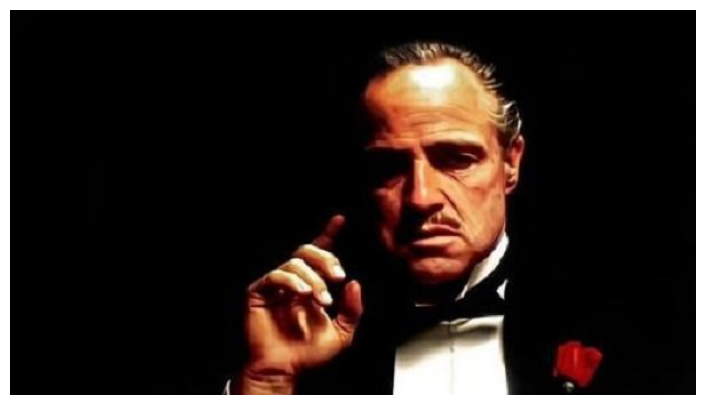

In [4]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(data[10][0])
plt.show()

In [5]:
ALPHA = 1
IMAGE_SIZE = 224
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224


In [6]:
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype = np.float32))
    for i in data[index][1]:
        x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
        x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
        y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1


In [7]:
X.shape

(409, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


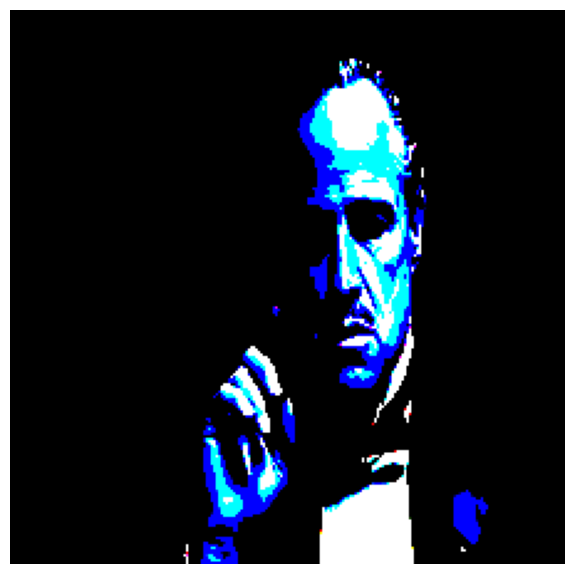

In [8]:
n = 10
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(X[n])

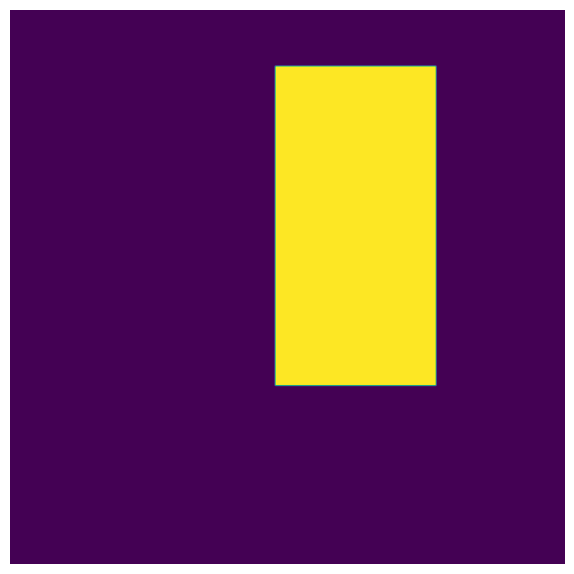

In [9]:
n = 10
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(masks[n])


In [10]:
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding = 'same', kernel_initializer = 'he_normal', strides = strides, name = prefix + '_conv')(prevlayer)
    conv = BatchNormalization(name = prefix + 'BatchNormalization')(conv)
    conv = Activation('relu', name = prefix + 'ActivationLayer')(conv)
    return conv

def create_model(trainable = True):
    model = MobileNet(input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top = False, alpha = ALPHA, weights = 'imagenet')
    for layer in model.layers:
        layer.trainable = trainable
    
    block1 = model.get_layer('conv_pw_13_relu').output
    block2 = model.get_layer('conv_pw_11_relu').output
    block3 = model.get_layer('conv_pw_5_relu').output
    block4 = model.get_layer('conv_pw_3_relu').output
    block5 = model.get_layer('conv_pw_1_relu').output
    
    up1 = Concatenate()([UpSampling2D()(block1), block2])
    conv6 = conv_block_simple(up1, 256, 'Conv_6_1')
    conv6 = conv_block_simple(conv6, 256, 'Conv_6_2')

    up2 = Concatenate()([UpSampling2D()(conv6), block3])
    conv7 = conv_block_simple(up2, 256, 'Conv_7_1')
    conv7 = conv_block_simple(conv7, 256, 'Conv_7_2')

    up3 = Concatenate()([UpSampling2D()(conv7), block4])
    conv8 = conv_block_simple(up3, 192, 'Conv_8_1')
    conv8 = conv_block_simple(conv8, 128, 'Conv_8_2')

    up4 = Concatenate()([UpSampling2D()(conv8), block5])
    conv9 = conv_block_simple(up4, 96, 'Conv_9_1')
    conv9 = conv_block_simple(conv9, 64, 'Conv_9_2')

    up5 = Concatenate()([UpSampling2D()(conv9), model.input])
    conv10 = conv_block_simple(up5, 48, 'Conv_10_1')
    conv10 = conv_block_simple(conv10, 32, 'Conv_10_2')
    conv10 = SpatialDropout2D(0.2)(conv10)
    
    x = Conv2D(1, (1, 1), activation = 'sigmoid')(conv10)
    x = Reshape((IMAGE_SIZE, IMAGE_SIZE))(x)
    return Model(inputs = model.input, outputs = x)


In [11]:
model = create_model(True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                             

 on)                                                                                              
                                                                                                  
 conv_dw_5_relu (ReLU)          (None, 28, 28, 256)  0           ['conv_dw_5_bn[0][0]']           
                                                                                                  
 conv_pw_5 (Conv2D)             (None, 28, 28, 256)  65536       ['conv_dw_5_relu[0][0]']         
                                                                                                  
 conv_pw_5_bn (BatchNormalizati  (None, 28, 28, 256)  1024       ['conv_pw_5[0][0]']              
 on)                                                                                              
                                                                                                  
 conv_pw_5_relu (ReLU)          (None, 28, 28, 256)  0           ['conv_pw_5_bn[0][0]']           
          

 conv_dw_11 (DepthwiseConv2D)   (None, 14, 14, 512)  4608        ['conv_pw_10_relu[0][0]']        
                                                                                                  
 conv_dw_11_bn (BatchNormalizat  (None, 14, 14, 512)  2048       ['conv_dw_11[0][0]']             
 ion)                                                                                             
                                                                                                  
 conv_dw_11_relu (ReLU)         (None, 14, 14, 512)  0           ['conv_dw_11_bn[0][0]']          
                                                                                                  
 conv_pw_11 (Conv2D)            (None, 14, 14, 512)  262144      ['conv_dw_11_relu[0][0]']        
                                                                                                  
 conv_pw_11_bn (BatchNormalizat  (None, 14, 14, 512)  2048       ['conv_pw_11[0][0]']             
 ion)     

                                                                                                  
 Conv_7_2ActivationLayer (Activ  (None, 28, 28, 256)  0          ['Conv_7_2BatchNormalization[0][0
 ation)                                                          ]']                              
                                                                                                  
 up_sampling2d_2 (UpSampling2D)  (None, 56, 56, 256)  0          ['Conv_7_2ActivationLayer[0][0]']
                                                                                                  
 concatenate_2 (Concatenate)    (None, 56, 56, 384)  0           ['up_sampling2d_2[0][0]',        
                                                                  'conv_pw_3_relu[0][0]']         
                                                                                                  
 Conv_8_1_conv (Conv2D)         (None, 56, 56, 192)  663744      ['concatenate_2[0][0]']          
          

In [12]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())


In [13]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())


In [14]:
adam = tf.keras.optimizers.legacy.Adam(lr = 1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)



model.compile(loss = loss, optimizer = adam, metrics = [dice_coefficient])


C:\installs\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
checkpoint = ModelCheckpoint('model_{loss:.2f}.h5', monitor = 'loss', verbose = 1, save_best_only = True, save_weights_only = True, mode = 'min', period = 1)
stop = EarlyStopping(monitor = 'loss', patience = 5, mode = 'min')
reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, min_lr = 1e-6, verbose = 1, mode = 'min')


In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X, masks, test_size = 0.15, random_state = 2019, shuffle = False)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((347, 224, 224, 3), (62, 224, 224, 3), (347, 224, 224), (62, 224, 224))

In [17]:
model.fit(X_train, y_train, epochs = 30, batch_size = 1, callbacks = [checkpoint, reduce_lr, stop], validation_data = (X_valid, y_valid))

Epoch 1/30
347/347 [==============================] - ETA: 0s - loss: 1.8661 - dice_coefficient: 0.3373
Epoch 1: loss improved from inf to 1.86612, saving model to model_1.87.h5
347/347 [==============================] - 185s 523ms/step - loss: 1.8661 - dice_coefficient: 0.3373 - val_loss: 1.4408 - val_dice_coefficient: 0.4075 - lr: 1.0000e-04
Epoch 2/30
347/347 [==============================] - ETA: 0s - loss: 1.3171 - dice_coefficient: 0.4414
Epoch 2: loss improved from 1.86612 to 1.31707, saving model to model_1.32.h5
347/347 [==============================] - 180s 519ms/step - loss: 1.3171 - dice_coefficient: 0.4414 - val_loss: 1.1810 - val_dice_coefficient: 0.4370 - lr: 1.0000e-04
Epoch 3/30
347/347 [==============================] - ETA: 0s - loss: 1.0414 - dice_coefficient: 0.5145
Epoch 3: loss improved from 1.31707 to 1.04140, saving model to model_1.04.h5
347/347 [==============================] - 178s 514ms/step - loss: 1.0414 - dice_coefficient: 0.5145 - val_loss: 1.1343 - 

Epoch 25/30
347/347 [==============================] - ETA: 0s - loss: 0.1176 - dice_coefficient: 0.9479
Epoch 25: loss improved from 0.12271 to 0.11760, saving model to model_0.12.h5
347/347 [==============================] - 353s 1s/step - loss: 0.1176 - dice_coefficient: 0.9479 - val_loss: 1.0721 - val_dice_coefficient: 0.5668 - lr: 1.0000e-04
Epoch 26/30
347/347 [==============================] - ETA: 0s - loss: 0.1178 - dice_coefficient: 0.9478
Epoch 26: loss did not improve from 0.11760
347/347 [==============================] - 343s 989ms/step - loss: 0.1178 - dice_coefficient: 0.9478 - val_loss: 0.9443 - val_dice_coefficient: 0.5938 - lr: 1.0000e-04
Epoch 27/30
347/347 [==============================] - ETA: 0s - loss: 0.1114 - dice_coefficient: 0.9527
Epoch 27: loss improved from 0.11760 to 0.11142, saving model to model_0.11.h5
347/347 [==============================] - 318s 917ms/step - loss: 0.1114 - dice_coefficient: 0.9527 - val_loss: 0.9186 - val_dice_coefficient: 0.6058

In [18]:
model.evaluate(X_valid, y_valid, verbose = 1)

2/2 [==============================] - 6s 3s/step - loss: 0.8564 - dice_coefficient: 0.6039


[0.8564427495002747, 0.6039037108421326]

In [19]:
# Load previous model weight
WEIGHTS_FILE = "model_0.11.h5"
learned_model = create_model()
learned_model.load_weights(WEIGHTS_FILE)
y_pred = learned_model.predict(X_valid, verbose = 1)



2/2 [==============================] - 7s 3s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


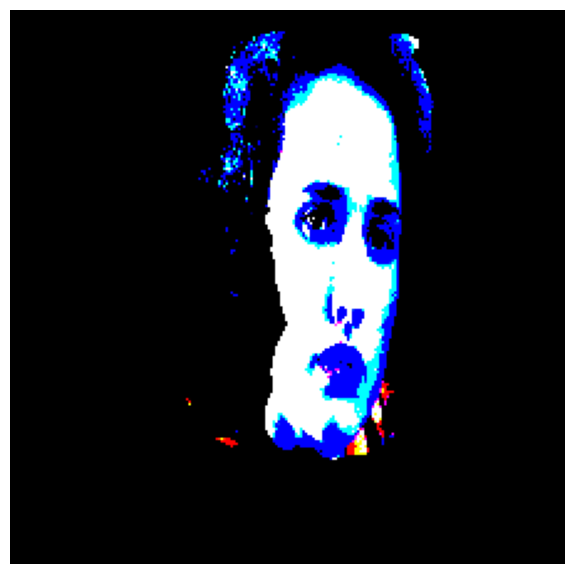

In [20]:
# For a sample image for index 4
n = 4
image = cv2.resize(X_valid[n], dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
pred_mask = cv2.resize(1.0*(y_pred[n] > 0.1), (IMAGE_WIDTH, IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]
out_image = image2

fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(out_image)


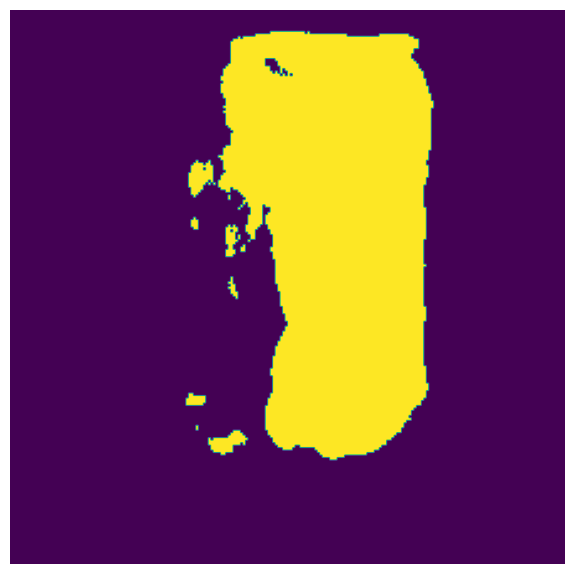

In [21]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(pred_mask, alpha = 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


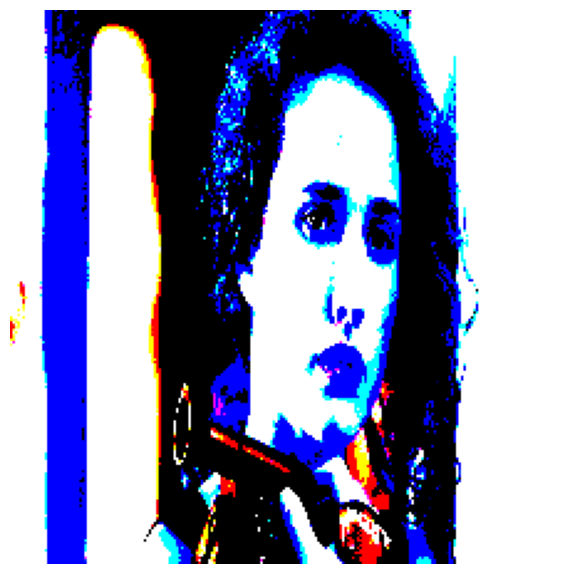

In [22]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(X_valid[n])
plt.savefig('image.jpg', bbox_inches = 'tight', pad_inches = 0)


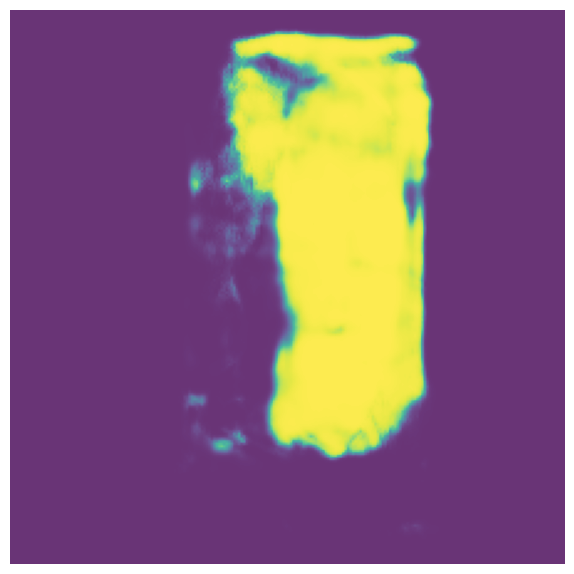

In [23]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(y_pred[n], alpha = 0.8)
plt.savefig('mask.jpg', bbox_inches = 'tight', pad_inches = 0)

part-B

In [24]:
# load image from file
filename = 'training_images/real_00001.jpg'
pixels = pyplot.imread(filename)
# create the detector, using default weights
detector = MTCNN()
# detect faces in the image
faces = detector.detect_faces(pixels)
for face in faces:
	print(face)

1/1 [==============================] - 0s 134ms/step
{'box': [147, 119, 356, 468], 'confidence': 0.9999990463256836, 'keypoints': {'left_eye': (281, 309), 'right_eye': (446, 286), 'nose': (402, 392), 'mouth_left': (323, 488), 'mouth_right': (448, 469)}}


1/1 [==============================] - 0s 114ms/step


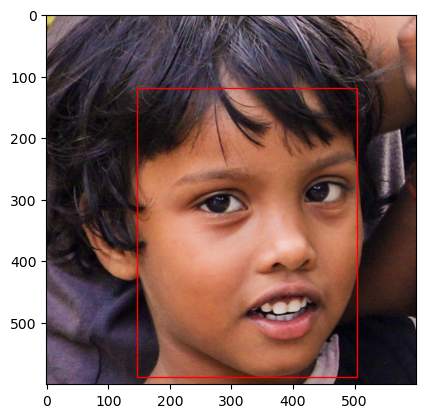

1/1 [==============================] - 0s 24ms/step
{'box': [147, 119, 356, 468], 'confidence': 0.9999990463256836, 'keypoints': {'left_eye': (281, 309), 'right_eye': (446, 286), 'nose': (402, 392), 'mouth_left': (323, 488), 'mouth_right': (448, 469)}}


In [25]:
# draw an image with detected objects
def draw_image_with_boxes(filename, result_list):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for result in result_list:
		# get coordinates
		x, y, width, height = result['box']
		# create the shape
		rect = Rectangle((x, y), width, height, fill=False, color='red')
		# draw the box
		ax.add_patch(rect)
	# show the plot
	pyplot.show()
 
filename = 'training_images/real_00001.jpg'
# load image from file
pixels = pyplot.imread(filename)
# create the detector, using default weights
detector = MTCNN()
# detect faces in the image
faces = detector.detect_faces(pixels)
# display faces on the original image
draw_image_with_boxes(filename, faces)
faces = detector.detect_faces(pixels)
for face in faces:
	print(face)

1/1 [==============================] - 0s 117ms/step


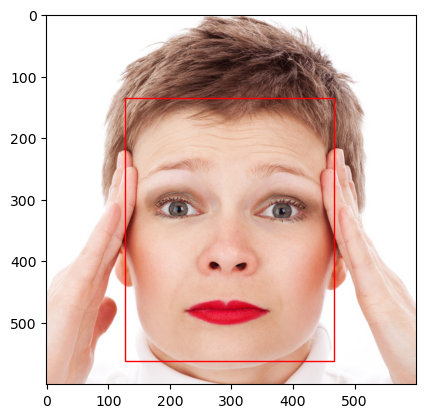

1/1 [==============================] - 0s 22ms/step
{'box': [127, 134, 339, 427], 'confidence': 0.9999639987945557, 'keypoints': {'left_eye': (218, 315), 'right_eye': (378, 319), 'nose': (293, 385), 'mouth_left': (227, 477), 'mouth_right': (360, 478)}}


In [26]:
filename = 'training_images/real_00002.jpg'
# load image from file
pixels = pyplot.imread(filename)
# create the detector, using default weights
detector = MTCNN()
# detect faces in the image
faces = detector.detect_faces(pixels)
# display faces on the original image
draw_image_with_boxes(filename, faces)
faces = detector.detect_faces(pixels)
for face in faces:
	print(face)


In [28]:
import os
from PIL import Image

input_dir = "training_images"

# load images one after another - useful for images one by one
for image in os.listdir(input_dir):
    img = Image.open(os.path.join(input_dir, image))
    # do whatever you like to do with the img

# load all images data at in to list
image_list = [Image.open(os.path.join(input_dir, image)) for image in os.listdir(input_dir)]


In [29]:
len(image_list)

1091

In [30]:
import os
from os import listdir
 
# get the path or directory
folder_dir = "training_images"
for images in os.listdir(folder_dir):
 
    # check if the image ends with png or jpg or jpeg
    if (images.endswith(".png") or images.endswith(".jpg")\
        or images.endswith(".jpeg")):
        # display
        print(images)

real_00001.jpg
real_00002.jpg
real_00003.jpg
real_00004.jpg
real_00005.jpg
real_00006.jpg
real_00007.jpg
real_00008.jpg
real_00009.jpg
real_00010.jpg
real_00011.jpg
real_00012.jpg
real_00013.jpg
real_00014.jpg
real_00015.jpg
real_00016.jpg
real_00017.jpg
real_00018.jpg
real_00019.jpg
real_00020.jpg
real_00021.jpg
real_00022.jpg
real_00023.jpg
real_00024.jpg
real_00025.jpg
real_00026.jpg
real_00027.jpg
real_00028.jpg
real_00029.jpg
real_00030.jpg
real_00031.jpg
real_00032.jpg
real_00033.jpg
real_00034.jpg
real_00035.jpg
real_00036.jpg
real_00037.jpg
real_00038.jpg
real_00039.jpg
real_00040.jpg
real_00041.jpg
real_00042.jpg
real_00043.jpg
real_00044.jpg
real_00045.jpg
real_00046.jpg
real_00047.jpg
real_00048.jpg
real_00049.jpg
real_00050.jpg
real_00051.jpg
real_00052.jpg
real_00053.jpg
real_00054.jpg
real_00055.jpg
real_00056.jpg
real_00057.jpg
real_00058.jpg
real_00059.jpg
real_00060.jpg
real_00061.jpg
real_00062.jpg
real_00063.jpg
real_00064.jpg
real_00065.jpg
real_00066.jpg
real_00067

In [31]:
df=pd.DataFrame(image_list)

In [32]:
df

0
0     <PIL.JpegImagePlugin.JpegImageFile image mode=...
1     <PIL.JpegImagePlugin.JpegImageFile image mode=...
2     <PIL.JpegImagePlugin.JpegImageFile image mode=...
3     <PIL.JpegImagePlugin.JpegImageFile image mode=...
4     <PIL.JpegImagePlugin.JpegImageFile image mode=...
...                                                 ...
1086  <PIL.JpegImagePlugin.JpegImageFile image mode=...
1087  <PIL.JpegImagePlugin.JpegImageFile image mode=...
1088  <PIL.JpegImagePlugin.JpegImageFile image mode=...
1089  <PIL.JpegImagePlugin.JpegImageFile image mode=...
1090  <PIL.JpegImagePlugin.JpegImageFile image mode=...

[1091 rows x 1 columns]

<h><font size=5>Part-C</font></h>

<h><font size=3>import libraries</font></h>

In [33]:
# Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, sklearn, re, random
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm
import tensorflow, cv2
%matplotlib inline

# Extract content from zipfile
from zipfile import ZipFile

# Model
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from sklearn.svm import SVC

# Encode, standardize and PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Set random_state
random_state = 2020

# Suppress warnings, if any
import warnings; warnings.filterwarnings('ignore')

# Print versions
print(f'Pandas version: {pd.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'Scikit-learn version: {sklearn.__version__}')
print(f'Tensorflow version: {tensorflow.__version__}')
print(f'CV version: {cv2.__version__}')

Pandas version: 1.4.4
Numpy version: 1.23.4
Scikit-learn version: 1.0.2
Tensorflow version: 2.11.0
CV version: 4.6.0


<h><font size=3>Extract the zip file</font></h>

In [34]:
with ZipFile('PINS.zip', 'r') as zip:
  zip.extractall()

Function to load images


Define a function to load the images from the extracted folder and map each image with person id


In [35]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    exts = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
                exts.append(ext)
    return np.array(metadata), exts

metadata, exts = load_metadata('PINS')
labels = np.array([meta.name for meta in metadata])

In [36]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

<font size=3>Load a sample image</font>

In [37]:
n = np.random.randint(1, len(metadata))
img_path = metadata[n].image_path()
img = load_image(img_path)

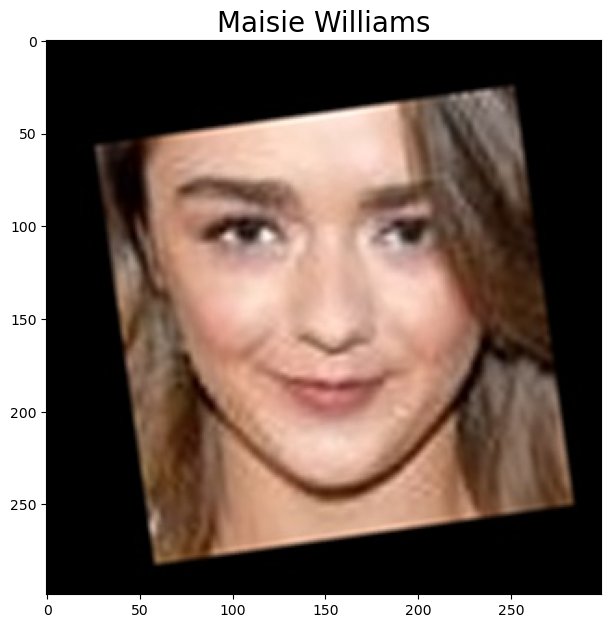

In [38]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
title = labels[n].split('_')[1]
ax.set_title(title, fontsize = 20)
_ = plt.imshow(img)


<font size=4>VGG Face model</font>

In [39]:
def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape = (224, 224, 3)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides =(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Convolution2D(4096, (7, 7), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

<font size=3>Load the given weight file named "vgg_face_weights.h5"</font>

In [40]:
model = vgg_face()
model.load_weights('vgg_face_weights.h5')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 226, 226, 3)      0         
 2D)                                                             
                                                                 
 conv2d_38 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 226, 226, 64)     0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                        

Get vgg_face_descriptor

In [41]:
vgg_face_descriptor = Model(inputs = model.layers[0].input, outputs = model.layers[-2].output)

Generate embeddings for each image in the dataset

Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model.

In [42]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0, 1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224, 224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis = 0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 0s 322ms/step
(2622,)


Generate embeddings for all images

In [43]:
embeddings = []
embeddings = np.zeros((metadata.shape[0], 2622))
for i, meta in tqdm(enumerate(metadata)):
  try:
    image = load_image(str(meta))
    image = (image/255.).astype(np.float32)
    image = cv2.resize(image, (224, 224))
    embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis = 0))[0]
  except:
    embeddings[i] = np.zeros(2622)

0it [00:00, ?it/s]

1/1 [==============================] - 0s 168ms/step


1/1 [==============================] - 0s 177ms/step


1/1 [==============================] - 0s 161ms/step


1/1 [==============================] - 0s 158ms/step


1/1 [==============================] - 0s 168ms/step


1/1 [==============================] - 0s 151ms/step


1/1 [==============================] - 0s 161ms/step


1/1 [==============================] - 0s 159ms/step


1/1 [==============================] - 0s 151ms/step


1/1 [==============================] - 0s 154ms/step


1/1 [==============================] - 0s 153ms/step


1/1 [==============================] - 0s 161ms/step


1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 166ms/step


1/1 [==============================] - 0s 153ms/step


1/1 [==============================] - 0s 160ms/step


1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 167ms/step


1/1 [==============================] - 0s 160ms/step


1/1 [==============================] - 0s 172ms/step


1/1 [==============================] - 0s 163ms/step


1/1 [==============================] - 0s 166ms/step


1/1 [==============================] - 0s 164ms/step


1/1 [==============================] - 0s 162ms/step


1/1 [==============================] - 0s 163ms/step


1/1 [==============================] - 0s 160ms/step


1/1 [==============================] - 0s 170ms/step


1/1 [==============================] - 0s 170ms/step


1/1 [==============================] - 0s 179ms/step


1/1 [==============================] - 0s 186ms/step


1/1 [==============================] - 0s 179ms/step


1/1 [==============================] - 0s 184ms/step


1/1 [==============================] - 0s 178ms/step


1/1 [==============================] - 0s 180ms/step


1/1 [==============================] - 0s 190ms/step


1/1 [==============================] - 0s 185ms/step


1/1 [==============================] - 0s 187ms/step


1/1 [==============================] - 0s 198ms/step


1/1 [==============================] - 0s 192ms/step


1/1 [==============================] - 0s 175ms/step


1/1 [==============================] - 0s 200ms/step


1/1 [==============================] - 0s 193ms/step


1/1 [==============================] - 0s 189ms/step


1/1 [==============================] - 0s 237ms/step


1/1 [==============================] - 0s 230ms/step


1/1 [==============================] - 0s 193ms/step


1/1 [==============================] - 0s 190ms/step


1/1 [==============================] - 0s 193ms/step


1/1 [==============================] - 0s 205ms/step


1/1 [==============================] - 0s 212ms/step


1/1 [==============================] - 0s 216ms/step


1/1 [==============================] - 0s 231ms/step


1/1 [==============================] - 0s 219ms/step


1/1 [==============================] - 0s 241ms/step


1/1 [==============================] - 0s 184ms/step


1/1 [==============================] - 0s 193ms/step


1/1 [==============================] - 0s 197ms/step


1/1 [==============================] - 0s 201ms/step


1/1 [==============================] - 0s 214ms/step


1/1 [==============================] - 0s 201ms/step


1/1 [==============================] - 0s 210ms/step


1/1 [==============================] - 0s 185ms/step


1/1 [==============================] - 0s 195ms/step


1/1 [==============================] - 0s 223ms/step


1/1 [==============================] - 0s 212ms/step


1/1 [==============================] - 0s 214ms/step


1/1 [==============================] - 0s 214ms/step


1/1 [==============================] - 0s 223ms/step


1/1 [==============================] - 0s 227ms/step


1/1 [==============================] - 0s 232ms/step


Function to calculate distance between given 2 pairs of images

In [44]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

Plot images and get distance between the pairs given below

In [45]:
def show_pair(idx1, idx2):
    plt.figure(figsize = (8, 3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()))

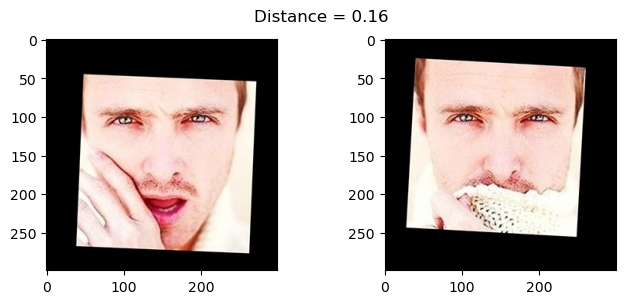

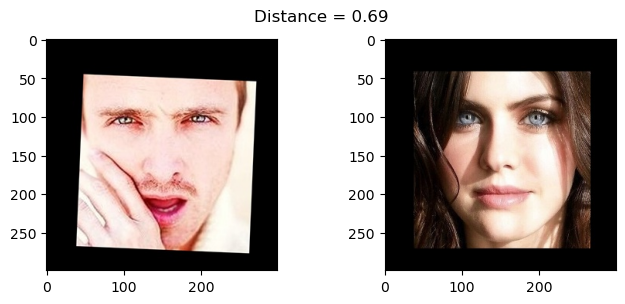

In [46]:
show_pair(2, 3)
show_pair(2, 180)

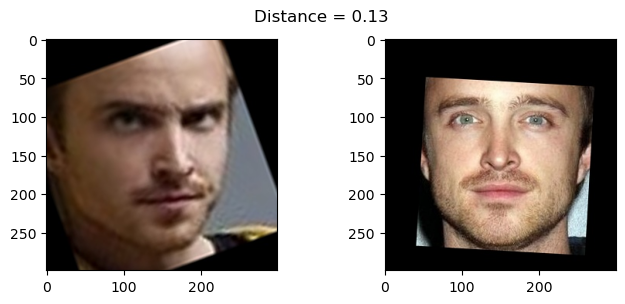

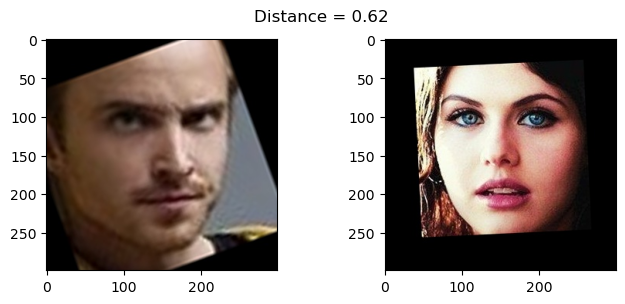

In [47]:
show_pair(30, 31)
show_pair(30, 100)

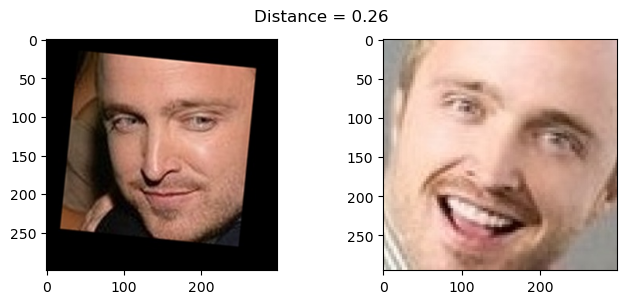

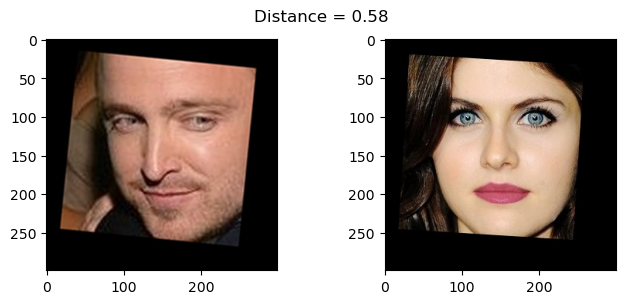

In [48]:
show_pair(70, 72)
show_pair(70, 115)

Create train and test sets

In [49]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# Features
X_train = np.array(embeddings)[train_idx]
X_test = np.array(embeddings)[test_idx]

# Labels
y_train = np.array([meta.name for meta in metadata[train_idx]])
y_test = np.array([meta.name for meta in metadata[test_idx]])

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9573, 2622)

(1197, 2622)

(9573,)

(1197,)

In [50]:
# Encode labels
en = LabelEncoder()
y_train = en.fit_transform(y_train)
y_test = en.transform(y_test)

In [51]:
# Standarize features
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

Reduce dimensions using PCA

In [52]:
# Covariance matrix
cov_matrix = np.cov(X_train_sc.T)

# Eigen values and vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Cumulative variance explained
tot = sum(eig_vals)
var_exp = [(i /tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

print('Cumulative Variance Explained', cum_var_exp)

Cumulative Variance Explained [ 13.58416795  18.94867841  22.94242516 ...  99.99999983  99.99999999
 100.        ]


In [53]:
# Get index where cumulative variance explained is > threshold
thres = 95
res = list(filter(lambda i: i > thres, cum_var_exp))[0]
index = (cum_var_exp.tolist().index(res))
print(f'Index of element just greater than {thres}: {str(index)}')

Index of element just greater than 95: 346


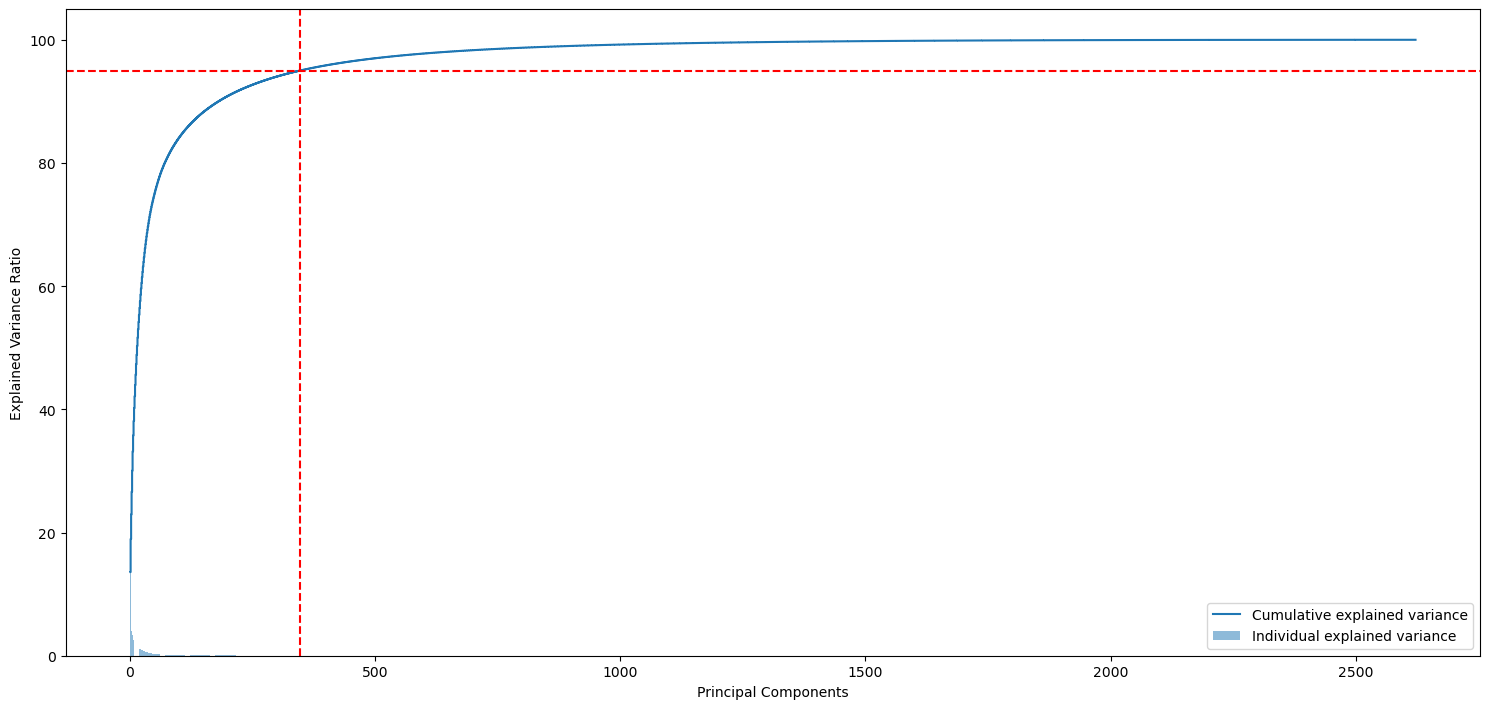

In [54]:
# Ploting 
plt.figure(figsize = (15 , 7.2))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where = 'mid', label = 'Cumulative explained variance')
plt.axhline(y = thres, color = 'r', linestyle = '--')
plt.axvline(x = index, color = 'r', linestyle = '--')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [55]:
# Reducing the dimensions
pca = PCA(n_components = index, random_state = random_state, svd_solver = 'full', whiten = True)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
display(X_train_pca.shape, X_test_pca.shape)

(9573, 346)

(1197, 346)

<font size=3>Build a Classifier</font>

In [56]:
svc_pca = SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced', random_state = random_state)
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

SVC accuracy for train set: 0.994


In [57]:
# Predict
y_pred = svc_pca.predict(X_test_pca)

# Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred).round(3)))

Accuracy Score: 0.966


In [58]:
names = [name.split('_')[1].title().strip() for name in labels]

# Classification Report
print('Classification Report: \n{}'.format(classification_report(y_test, y_pred, target_names = np.unique(names))))

Classification Report: 
                          precision    recall  f1-score   support

              Aaron Paul       1.00      1.00      1.00        10
      Alexandra Daddario       0.91      1.00      0.95        10
            Alvaro Morte       1.00      1.00      1.00        14
Alycia Debnam Carey Face       1.00      1.00      1.00        12
             Amanda Crew       1.00      1.00      1.00         7
          Amaury Nolasco       1.00      0.89      0.94         9
        Amber Heard Face       1.00      1.00      1.00         7
               Anna Gunn       1.00      1.00      1.00        14
           Anne Hathaway       1.00      1.00      1.00        14
     Barbara Palvin Face       1.00      1.00      1.00         9
      Bellamy Blake Face       0.87      0.93      0.90        14
    Benedict Cumberbatch       1.00      1.00      1.00        12
            Betsy Brandt       1.00      1.00      1.00        10
              Bill Gates       1.00      0.90      

<font size=3>Test results</font>

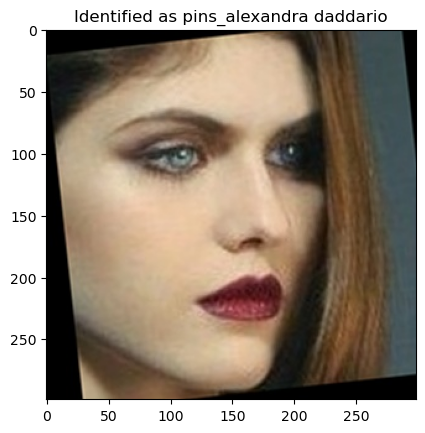

In [124]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_image_scal = sc.transform([embeddings[test_idx][example_idx]])
example_image_pca = pca.transform(example_image_scal)
example_prediction = svc_pca.predict(example_image_pca)
example_identity = en.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

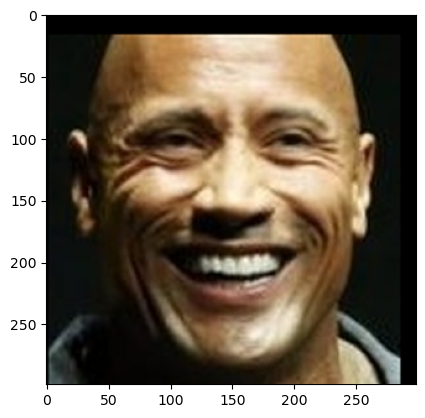

In [125]:
import imageio as iio
test_img1 = iio.imread("Dwayne+Johnson4.jpg")
plt.imshow(test_img1)

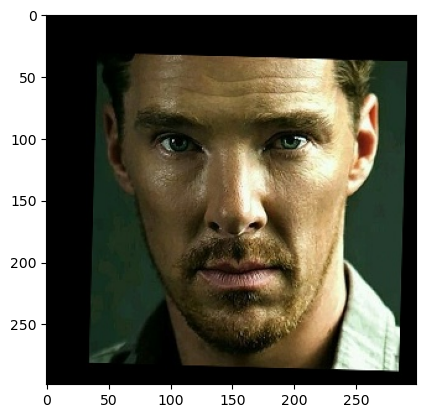

In [126]:
import imageio as iio
test_img2 = iio.imread("Benedict+Cumberbatch9.jpg")
plt.imshow(test_img2)

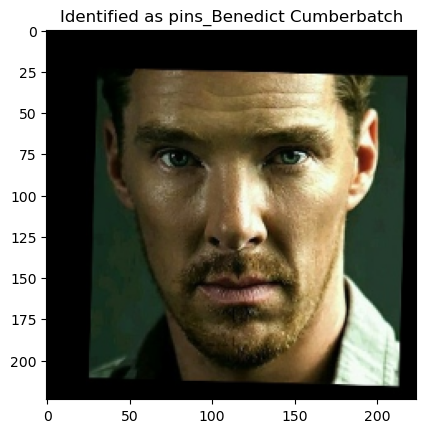

In [147]:
import warnings
warnings.filterwarnings('ignore')
test_img_path="Benedict+Cumberbatch9.jpg"

sample_img = load_image(test_img_path)
sample_img = (sample_img/255.).astype(np.float32)
  # Resize
sample_img = cv2.resize(sample_img, (224, 224))

sample_image_scal = sc.transform([embeddings[test_idx][150]])
sample_image_pca = pca.transform(sample_image_scal)
sample_prediction = svc_pca.predict(sample_image_pca)
sample_identity = en.inverse_transform(sample_prediction)[0]

plt.imshow(sample_img)
plt.title(f'Identified as {sample_identity}');

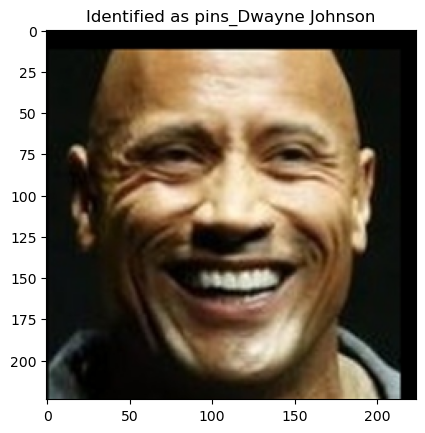

In [151]:
import warnings
warnings.filterwarnings('ignore')
test_img_path="Dwayne Johnson4.jpg"

sample_img = load_image(test_img_path)
sample_img = (sample_img/255.).astype(np.float32)
  # Resize
sample_img = cv2.resize(sample_img, (224, 224))

sample_image_scal = sc.transform([embeddings[test_idx][390]])
sample_image_pca = pca.transform(sample_image_scal)
sample_prediction = svc_pca.predict(sample_image_pca)
sample_identity = en.inverse_transform(sample_prediction)[0]

plt.imshow(sample_img)
plt.title(f'Identified as {sample_identity}');

Conclusion

Task here was to recognize (aligned) faces from a dataset containing 10k+ images for 100 people using a pre-trained model on Face Recognition.

VGG model with pre-trained weights was used to generate embeddings for each images in the dataset.

Distance between two pair of images were also calculated and plotted.

Since, there were 2,622 features for each image, PCA was used for dimension reduction after standardizing the features.
With an cumulative explained variance of 95%, 347 PCA components were used.

Using SVC we predicted the labels for test dataset with an accuracy of more than 96%.

Also compared predicted and actual labels for a given sample image as well as for 20 random images from test dataset.